In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import os
import seaborn as sns
from tqdm import tqdm
import csv
import missingno as msno

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Calculate Sentiment Index

## Load the Model

In [2]:
# Load model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [3]:
def calculate_sentence_sentiment(sentence):
    encoded_input = tokenizer(sentence, truncation=True, padding=True, return_tensors='pt')
     
    with torch.no_grad():
        output = model(**encoded_input)
    probs = torch.nn.functional.softmax(output.logits, dim=-1)
    
    # Compute weighted sentiment score
    # class 0 is negative, class 1 is neutral, class 2 is positive:
    sentiment_score = (-1 * probs[0][0].item()) + (0 * probs[0][1].item()) + (1 * probs[0][2].item())
    
    return sentiment_score

# Apply to dataset

download dataset from here

https://www.ecb.europa.eu/press/key/html/downloads.en.html

In [ ]:
df = pd.read_csv('all_ECB_speeches.csv',
                 engine='python',
                 delimiter='|',
                 quoting=csv.QUOTE_NONE,
                 escapechar='\\')

df.set_index('date', inplace=True)
df.sort_index(inplace=True)

target_speakers = [
    "Christine Lagarde",
    "Mario Draghi",
    "Jean-Claude Trichet",
    "Willem F. Duisenberg"
]

df = df[df['speakers'].isin(target_speakers)].dropna(subset=['speakers'])
df

,speakers,title,subtitle,contents
date,,,,
1997-06-30,Willem F. Duisenberg,Farewell to a Central banker,"Address by Dr. W. F. Duisenberg, President of ...",Farewell to a Central banker Address by Dr...
1997-09-12,Willem F. Duisenberg,From the EMI to the ESCB: Achievements and cha...,"Speech delivered by Dr. W. F. Duisenberg,Presi...",From the EMI to the ESCB: Achievements and c...
1997-09-22,Willem F. Duisenberg,The European Monetary Institute and progress t...,"Speech delivered by Dr. W. F. Duisenberg, Pres...",The European Monetary Institute and progress...
1997-10-13,Willem F. Duisenberg,Hearing of the President of the EMI by the Mo...,Introductory statement delivered by Dr. W. F. ...,Hearing of the President of the EMI by the M...
1997-10-14,Willem F. Duisenberg,Monetary stability and economic growth or: Why...,"Speech delivered by Dr. W.F. Duisenberg, Presi...",Monetary stability and economic growth or: W...
...,...,...,...,...
2024-11-18,Christine Lagarde,The economic and human challenges of a transfo...,"Speech by Christine Lagarde, President of the ...",SPEECH The economic and human challenges of...
2024-11-22,Christine Lagarde,Follow the money: channelling savings into inv...,"Speech by Christine Lagarde, President of the ...",SPEECH Follow the money: channelling saving...
2024-12-04,Christine Lagarde,Hearing of the Committee on Economic and Monet...,"Speech by Christine Lagarde, President of the ...",SPEECH Hearing of the Committee on Economic...


In [6]:
df.shape

(791, 4)

In [ ]:
def filter_rows_by_word_count(df, column, min_words):
    """
    Filter rows based on a minimum word count in a specified column.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The column from which to count words.
        min_words (int): The minimum number of words required.

    Returns:
        pd.DataFrame: A DataFrame containing rows that meet the word count criteria.
    """
    return df[df[column].str.split().str.len() >= min_words]

min_required_words = 100
df = filter_rows_by_word_count(df, 'contents', min_required_words)

## Apply to a single speech

In [ ]:
for i in tqdm(range(1)):
    text = df['contents'].iloc[i]
    sentiment = calculate_sentence_sentiment(text)
    date = df.index[i]

    print("Speech Text:\n", text, "\n")
    print("Sentiment Score:", sentiment)

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Speech Text:
   Farewell to a Central banker   Address by Dr. W. F. Duisenberg, President of De Nederlandsche Bank, on the occasion of Baron A. Lamfalussy's farewell as President of the European Monetary Institute, 30 June 1997. Dear Alexandre,  1. Three and a half years ago, when you exchanged the premises of the Bank for International Settlements, an established international financial institution, for a couple of floors in a Frankfurter "Hochhaus", you took on a huge task. Your first mission was to set up the European Monetary Institute (EMI), more or less starting from scratch. Moreover, you were faced with the responsibility of managing the preparations for Economic and Monetary Union (EMU). It was not an easy decision to embark on a grand project like EMU, but putting the flesh on the bones of monetary union is even more difficult. To be honest, at that time I would not like to have been in your shoes.  2. On both accounts you did a great job. The EMI is currently a thriving orga

## Apply to the whole dataset

In [8]:
sentiments_data = []

for i in tqdm(range(len(df))):
    text = df['contents'].iloc[i]
    sentiment = calculate_sentence_sentiment(text)
    date = df.index[i] 

    sentiments_data.append({'date': date, 'sentiment': sentiment})

100%|██████████| 789/789 [03:31<00:00,  3.74it/s]


In [9]:
# Convert the 'date' column to datetime and set it as the index
sentiments_df = pd.DataFrame(sentiments_data)
sentiments_df['date'] = pd.to_datetime(sentiments_df['date'])
sentiments_df.set_index('date', inplace=True)
sentiments_df.sort_index(inplace=True)

<Axes: title={'center': 'Raw Sentiment Score of ECB Speeches'}, xlabel='date'>

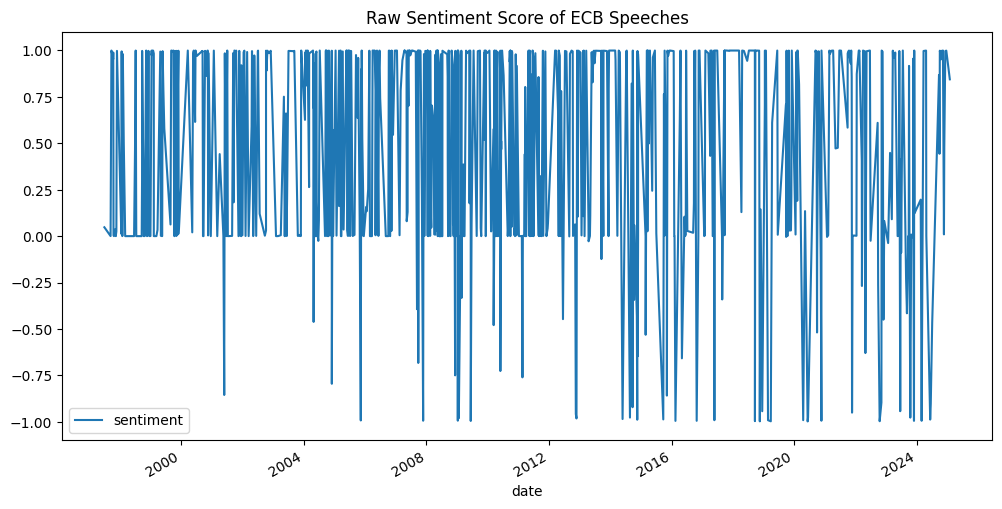

In [10]:
sentiments_df.plot(figsize=(12, 6), title='Raw Sentiment Score of ECB Speeches')

# Explainability

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer


# Create the explainer with model and tokenizer
cls_explainer = SequenceClassificationExplainer(
    model, tokenizer, custom_labels=["negative", "neutral", "positive"]
)
# Analyze your text
attributions = cls_explainer("For consumption, one useful indicator is the gap between essential purchases, such as food and rent, and non-essential ones, such as electrical goods and holidays. Non-essential purchases, which make up around 50% of household spending in the euro area, tend to be postponed during recessions and then to catch up as the business cycle advances.Such purchases are currently only 2% above their pre-crisis level, compared with 9% for essential ones. This implies that discretionary household spending still has scope to support the expansion.")
print(attributions)

[('<s>', 0.0), ('For', 0.050776227572814), ('consumption', 0.07351987398201913), (',', -0.025126835304021024), ('one', -0.0545799230199879), ('useful', 0.05223465025968326), ('indicator', 0.058239788680611214), ('is', -0.04728099563737873), ('the', 0.046515312403126036), ('gap', -0.07741420801010196), ('between', -0.049354629671368784), ('essential', 0.05217882723930564), ('purchases', 0.06690924419679341), (',', -0.007144328071109235), ('such', 0.03566004418671081), ('as', 0.026274195132781602), ('food', 0.049246778571302205), ('and', 0.015308471017645759), ('rent', 0.0011748527109711364), (',', 0.006495789427002507), ('and', 0.04015381213081842), ('non', -0.005170544636672391), ('-', -0.005934265485620245), ('essential', 0.039450156597329214), ('ones', 0.01987627104425959), (',', -0.016551075196727372), ('such', -0.0026943733038195528), ('as', 0.004361673170570461), ('electrical', 0.020046984220690883), ('goods', 0.051057790173274595), ('and', 0.0059958584992296695), ('holidays', 0.0

draghi positive
https://www.ecb.europa.eu/press/key/date/2018/html/ecb.sp180314_1.en.html

lagarde negative
https://www.ecb.europa.eu/press/key/date/2022/html/ecb.sp221104_1~8be9a4f4c1.en.html

In [ ]:
cls_explainer.visualize("distilbert_example2.html")

# Preprocess

In [40]:
# Group by month end ('ME') and calculate the mean sentiment
dfM = sentiments_df.resample('ME').mean()

<Axes: >

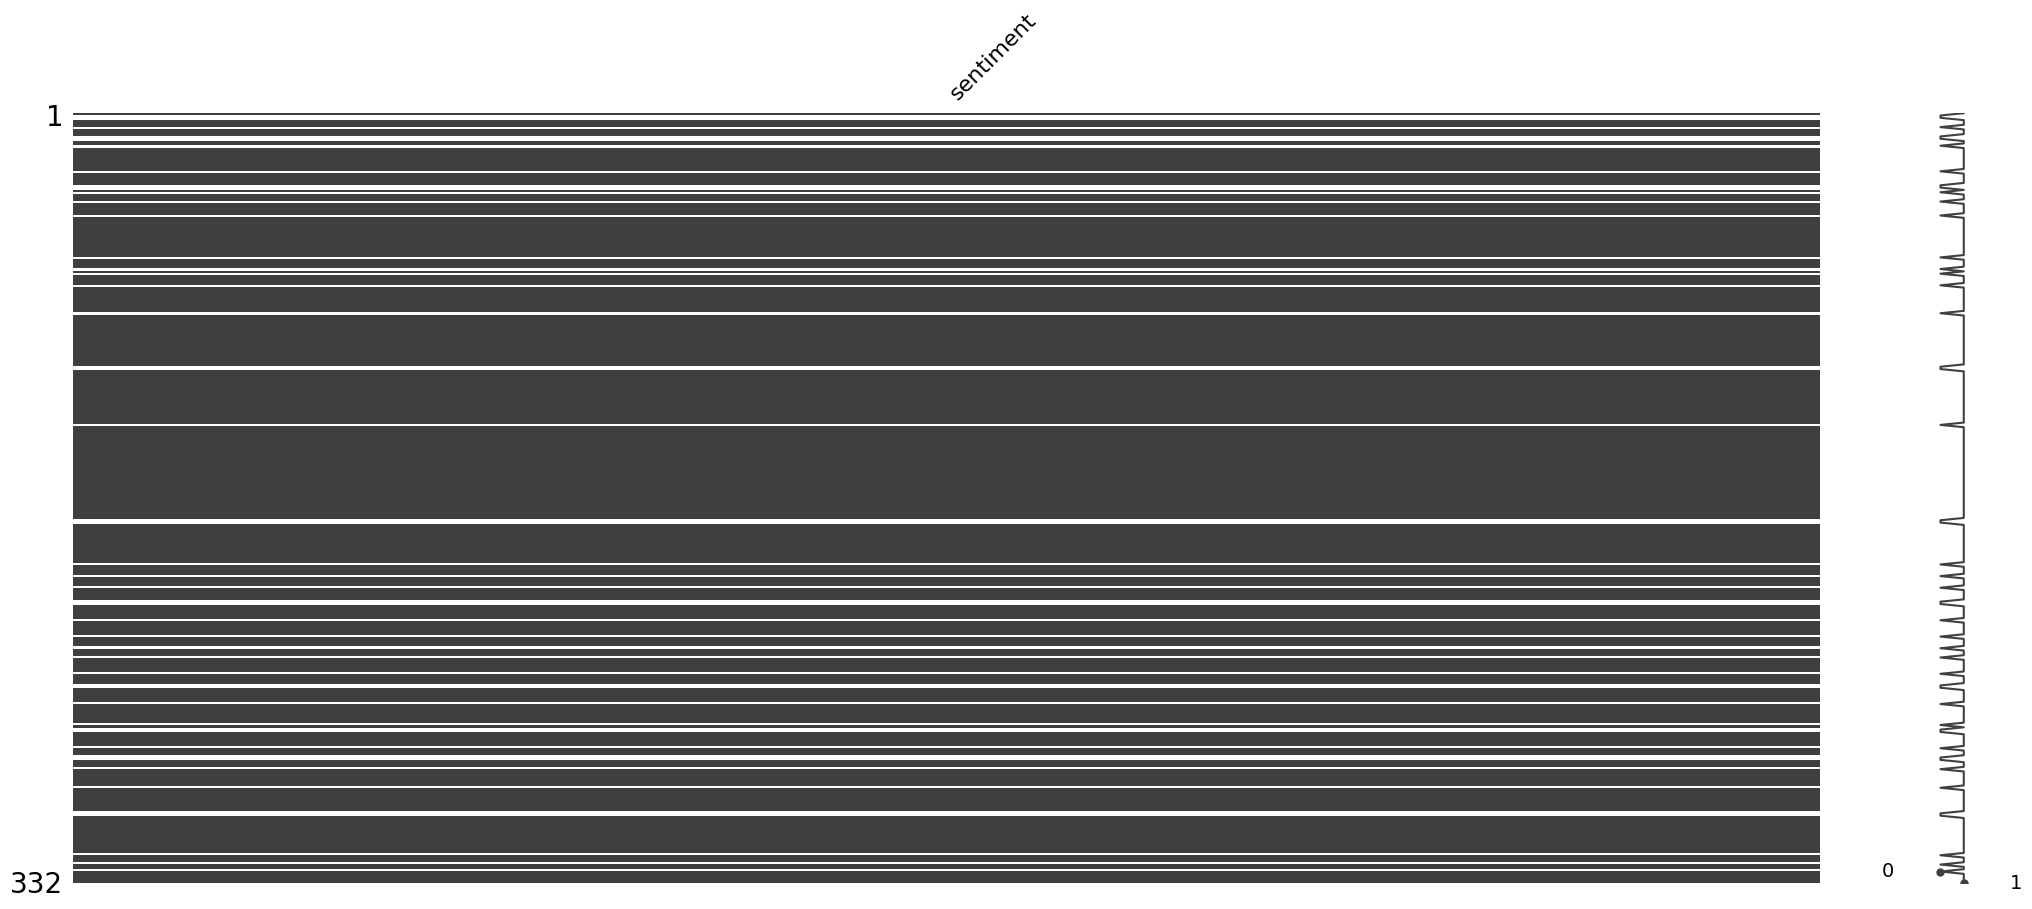

In [41]:
msno.matrix(dfM)

<Axes: title={'center': 'Interpolated Sentiment Score of ECB Speeches'}, xlabel='date'>

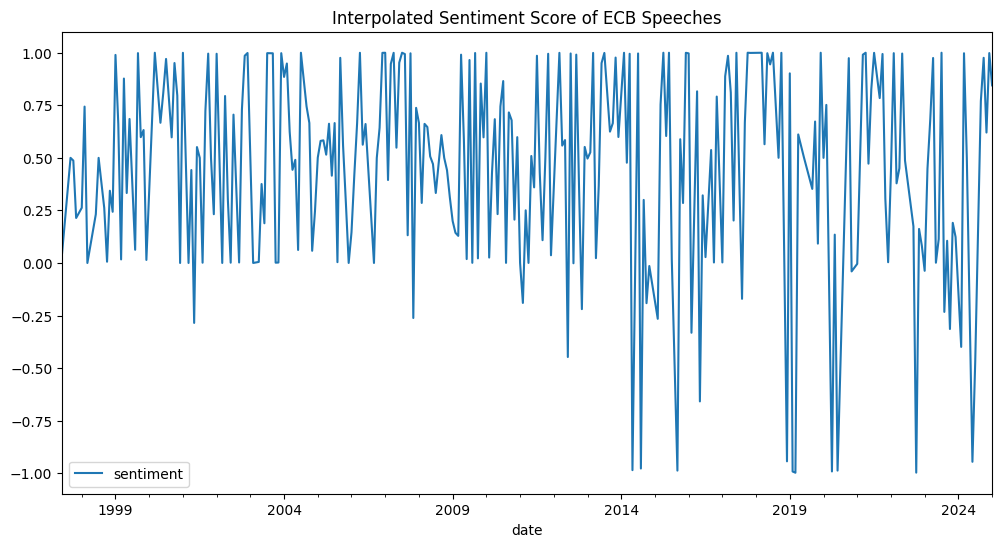

In [42]:
# Interpolate missing values in the DataFrame
dfM = dfM.interpolate(method='linear')

dfM.plot(figsize=(12, 6), title='Interpolated Sentiment Score of ECB Speeches')

# Smooth the Results

In [75]:
dfM.index = pd.to_datetime(dfM.index)
df1_monthly = dfM.resample('MS').first() 

dfM_aligned = dfM.copy()
dfM_aligned.index = dfM_aligned.index.to_period('M').to_timestamp('s')  

In [ ]:
from fredapi import Fred

fred = Fred(api_key='INSERT YOUR API') # Get your API key from https://research.stlouisfed.org/docs/api/api_key.html
#WITHOUT API RUN THE CELL BELLOW

R = fred.get_series('OECDEUROPERECDM')
C = fred.get_series('CSCICP03EZM665S')
I = fred.get_series('CPHPTT01EZM659N')
IP = fred.get_series('EA19PRINTO01GYSAM')
U = fred.get_series('LRHUTTTTEZM156S')


R.index = pd.to_datetime(R.index)
R_monthly = R.resample('MS').max().fillna(0).astype(int)
R_monthly.name = 'Recession'

C = C.resample('MS').first()
I = I.resample('MS').first()
IP = IP.resample('MS').first()
U = U.resample('MS').first()


df = pd.concat([dfM_aligned, R_monthly, C, I, IP, U], axis=1)
df.columns = ['Sentiment','Recession', 'Consumer Confidence', 'Inflation', 'Industrial Production', 'Unemployment']


df['Recession'] = df['Recession'].fillna(0)

df = df.dropna(subset=['Sentiment'])

# Plot time series

In [ ]:
# df = pd.read_csv('sentiment_dataset.csv', index_col=0, parse_dates=True)
# df.index = pd.to_datetime(df.index)
# df = df.resample('MS').last() 


In [82]:
# Create an explicit copy of the filtered DataFrame
filtered_merged_df = df.copy()

# Apply 6m SMA to Sentiment
filtered_merged_df.loc[:, 'Sentiment_SMA'] = filtered_merged_df['Sentiment'].rolling(window=6, center=False).mean()

# Drop NaNs from the sentiment columns
filtered_merged_df.dropna(subset=['Sentiment', 'Sentiment_SMA'], inplace=True)


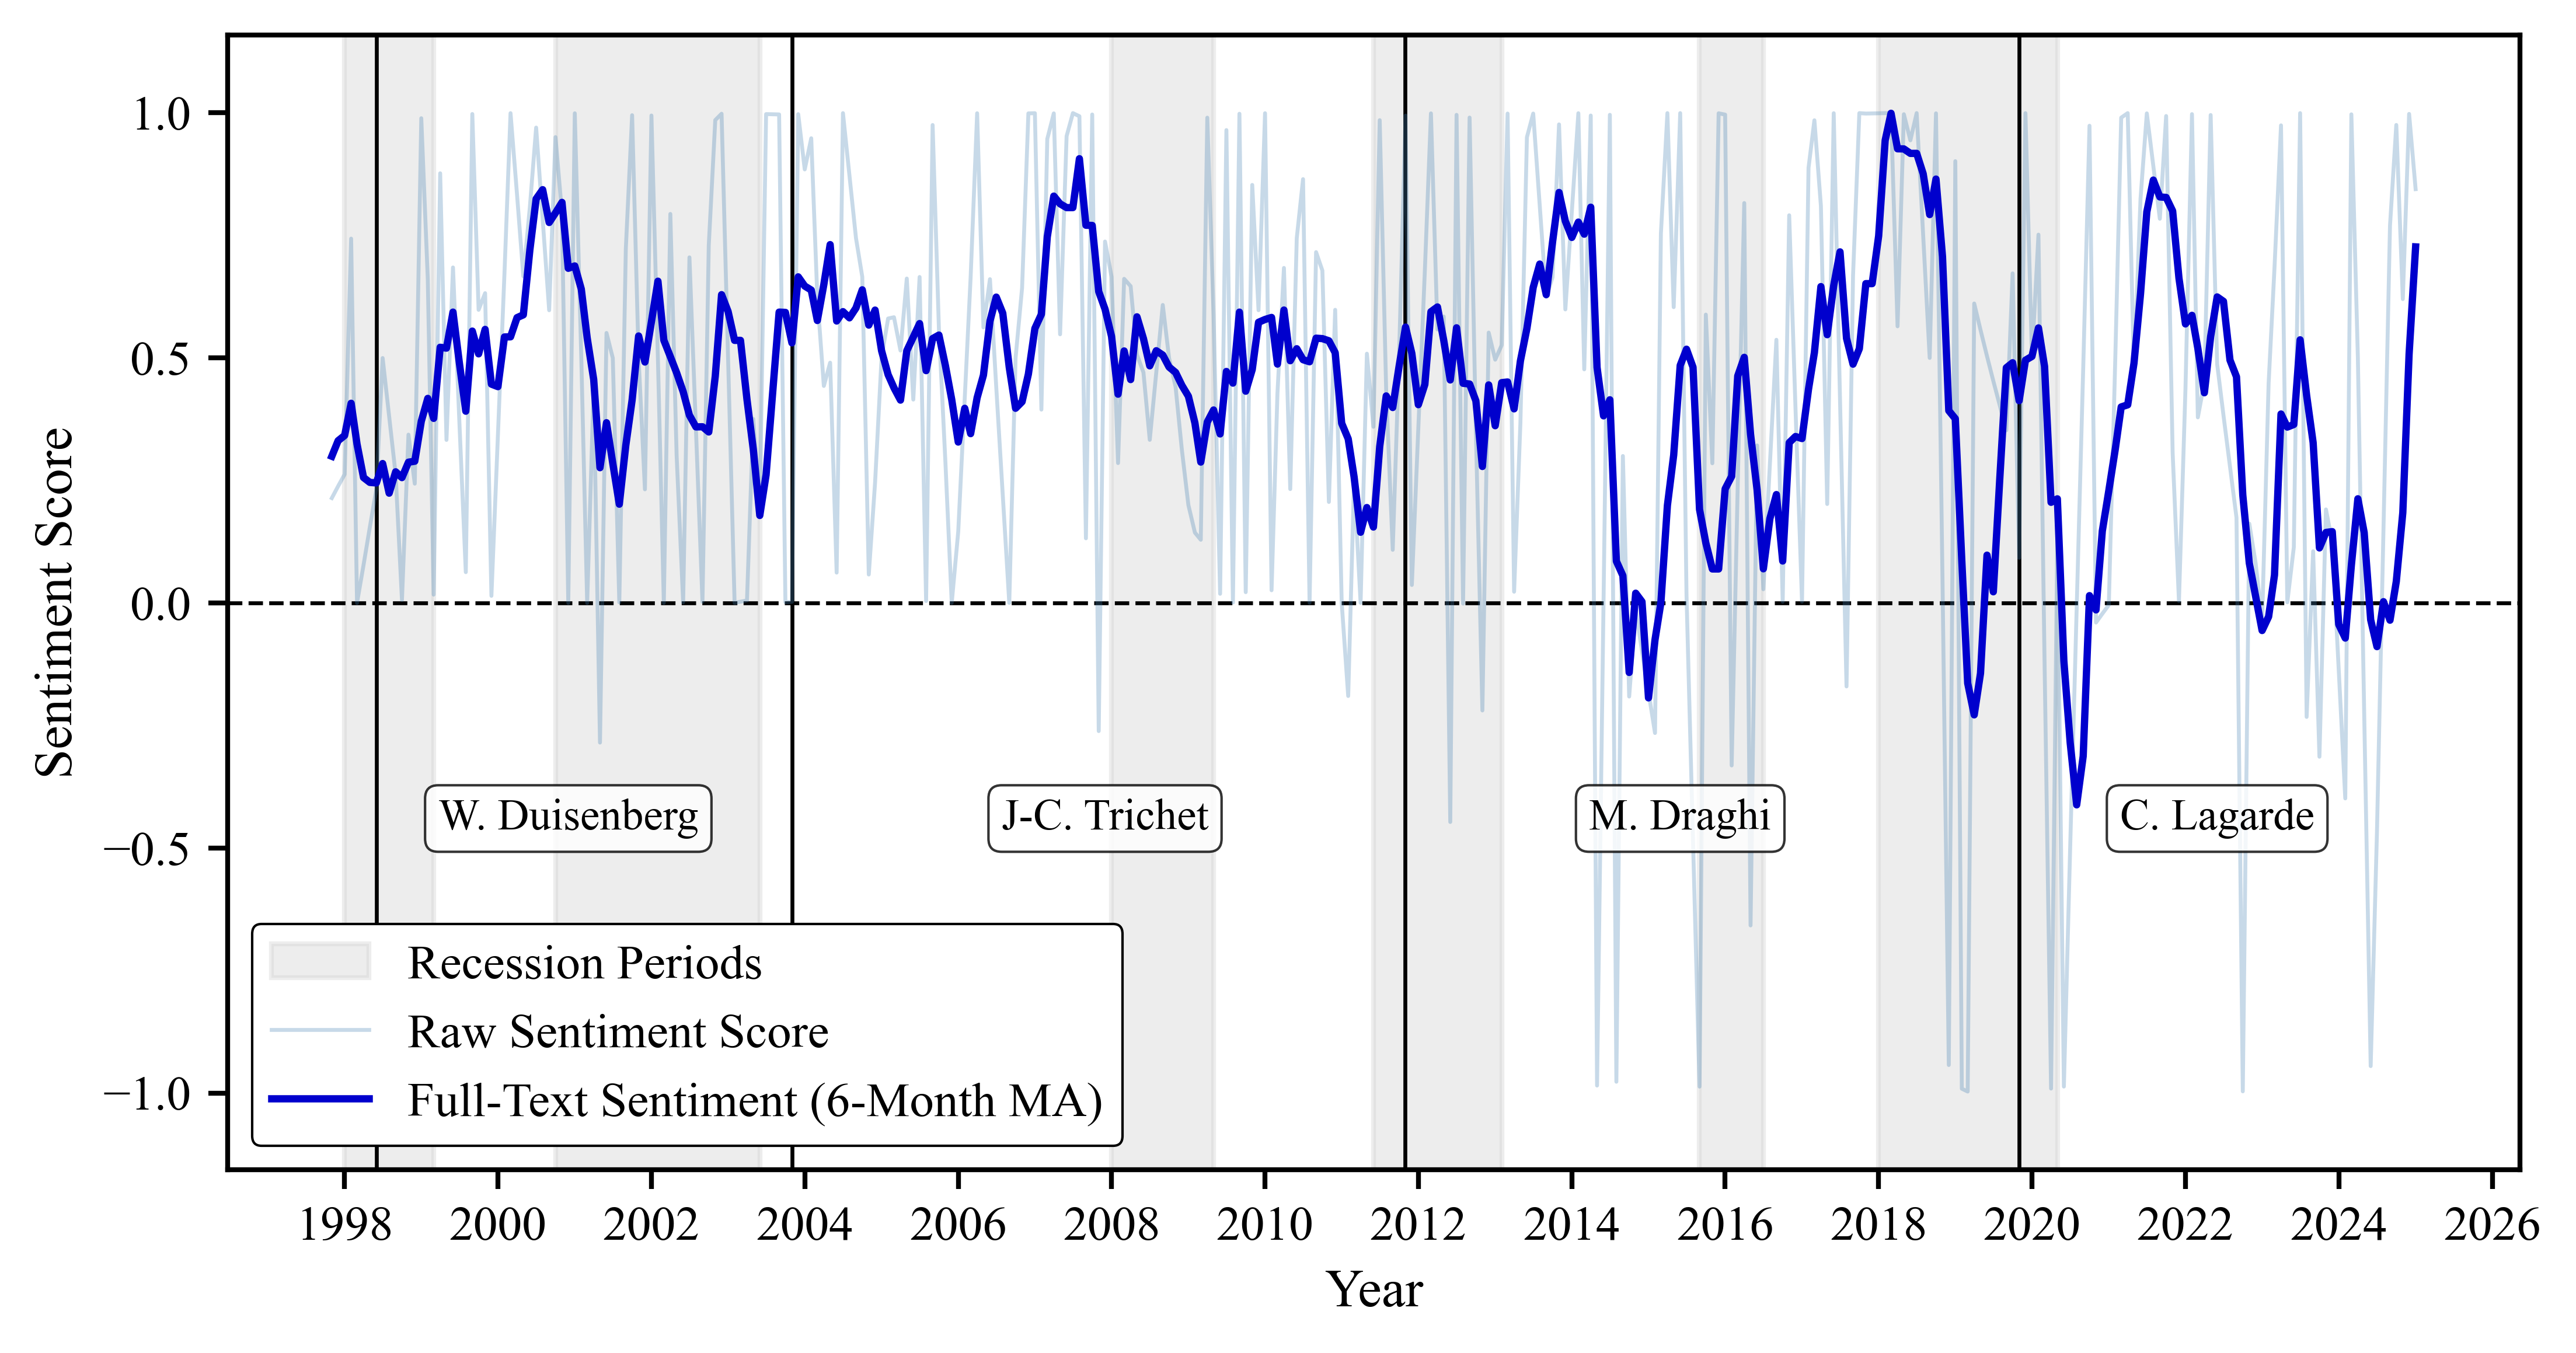

In [ ]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.linewidth': 1.0,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5
})

y_min, y_max = filtered_merged_df['Sentiment'].min(), filtered_merged_df['Sentiment'].max()
y_buffer = (y_max - y_min) * 0.08  # Add 15% buffer
y_plot_min, y_plot_max = y_min - y_buffer, y_max + y_buffer
fig, ax = plt.subplots(figsize=(7.5, 4), dpi=600)



# Add recession shading
if 'Recession' in filtered_merged_df.columns:
    recession_periods = filtered_merged_df['Recession'] == 1
    ax.fill_between(filtered_merged_df.index, y_plot_min, y_plot_max, 
                    where=recession_periods, 
                    color='lightgray', alpha=0.4, label='Recession Periods',
                    zorder=1)

# Plot sentiment lines 
ax.plot(filtered_merged_df['Sentiment'], color='steelblue', alpha=0.3, 
        label='Raw Sentiment Score', zorder=2, linewidth=0.8)
ax.plot(filtered_merged_df['Sentiment_SMA'], color='mediumblue', 
       label='Full-Text Sentiment (6-Month MA)', zorder=3, linewidth=1.5)

# Set axis limits
ax.set_ylim(y_plot_min, y_plot_max)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, zorder=1)

# ECB presidential dividers
president_dates = ['1998-06-01', '2003-11-01', '2011-10-31', '2019-11-01']
for date in president_dates:
    ax.axvline(pd.Timestamp(date), color='black', linestyle='-', linewidth=0.8, zorder=1)

# Improved text box style
text_box_style = dict(facecolor='white', 
                      alpha=0.8,
                      edgecolor='black', 
                      boxstyle='round,pad=0.3',
                      linewidth=0.5)

# President name annotations
president_names = [
    ('2000-12-01', 'W. Duisenberg'), 
    ('2007-12-01', 'J-C. Trichet'), 
    ('2015-06-01', 'M. Draghi'), 
    ('2022-06-01', 'C. Lagarde')
]
y_pos = y_plot_min + 0.3 * (y_plot_max - y_plot_min)
for date, name in president_names:
    ax.text(pd.Timestamp(date), y_pos, name, fontsize=9, ha='center', 
            bbox=text_box_style)

ax.set_ylabel('Sentiment Score', fontsize=11)
ax.set_xlabel('Year', fontsize=11)

# Format axes
for spine in ax.spines.values():
    spine.set_linewidth(1.0)
    spine.set_color('black')
ax.tick_params(axis='both', width=1.0, length=4, color='black')

# Format x-axis to show years
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)


legend = ax.legend(loc='lower left', frameon=True, framealpha=1, 
                  borderaxespad=0.5, edgecolor='black', fancybox=True)
legend.get_frame().set_linewidth(0.5)


plt.tight_layout(pad=1.1)

# Save
plt.savefig('ecb_sentiment_analysis1.pdf', dpi=600, bbox_inches='tight')
plt.savefig('ecb_sentiment_analysis1.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# statistics calculations

president_periods = [
    ('Beginning', '2003-11-01', 'W. Duisenberg'),
    ('2003-11-01', '2011-10-31', 'J-C. Trichet'),
    ('2011-10-31', '2019-11-01', 'M. Draghi'),
    ('2019-11-01', 'End', 'C. Lagarde')
]


results = pd.DataFrame(columns=['President', 'Mean', 'Std Dev'])

# Calculate statistics for each period
for i, (start, end, president) in enumerate(president_periods):
    if start == 'Beginning':
        if end == 'End':
            period_data = filtered_merged_df
        else:
            period_data = filtered_merged_df[filtered_merged_df.index < pd.Timestamp(end)]
    elif end == 'End':
        period_data = filtered_merged_df[filtered_merged_df.index >= pd.Timestamp(start)]
    else:
        period_data = filtered_merged_df[(filtered_merged_df.index >= pd.Timestamp(start)) & 
                                        (filtered_merged_df.index < pd.Timestamp(end))]
    
    
    mean_raw = period_data['Sentiment'].mean()
    std_raw = period_data['Sentiment'].std()

    results.loc[i] = [president, mean_raw, std_raw]


print(results)


overall_mean_raw = filtered_merged_df['Sentiment'].mean()
overall_std_raw = filtered_merged_df['Sentiment'].std()

print("\nOverall Statistics:")
print(f"Mean: {overall_mean_raw:.4f}, Std Dev: {overall_std_raw:.4f}")

       President      Mean   Std Dev
0  W. Duisenberg  0.470702  0.362600
1   J-C. Trichet  0.510414  0.338024
2      M. Draghi  0.428992  0.557775
3     C. Lagarde  0.310992  0.552070

Overall Statistics:
Mean: 0.4393, Std Dev: 0.4642
